In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  9 16:32:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d mcagriaksoy/trees-in-satellite-imagery

 91% 29.0M/31.8M [00:01<00:00, 24.6MB/s]
100% 31.8M/31.8M [00:01<00:00, 17.5MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('trees-in-satellite-imagery.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/Trees in Sat Images') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
DATADIR = "/Trees in Sat Images/Trees in Satellite Imagery"
img_height = 64
img_width = 64
batch_size = 32

In [ ]:
train_ds = image_dataset_from_directory(
    DATADIR,
    validation_split = 0.3,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10400 files belonging to 2 classes.
Using 7280 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
    DATADIR,
    validation_split = 0.3,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = 32)


Found 10400 files belonging to 2 classes.
Using 3120 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['NoTrees', 'Trees']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


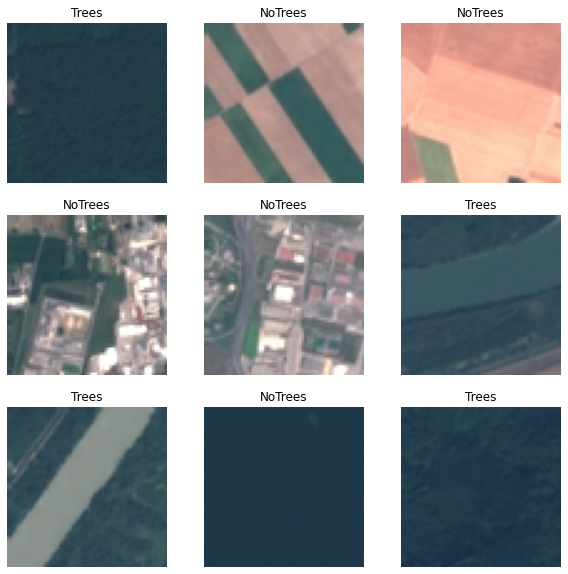

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32,)


## ResNet Using Keras video method

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

In [ ]:
def identity_block(X, f, filters):
  F1, F2, F3 = filters

  X_shortcut = X

  # First Layer
  X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  # Second Layer
  X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  # Third Layer
  X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)

  # Final step, add our saved shortcut input to our new output
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [ ]:
def convolutional_block(X, f, filters, s = 2):
  F1, F2, F3 = filters

  X_shortcut = X

  # First Layer
  X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  # Second Layer
  X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  # Third Layer
  X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)

  # Shortcut Path
  X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s), padding = 'valid')(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

  # Final step, add our saved shortcut input to our new output
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [ ]:
def ResNet50(input_shape = (64,64,3), classes=2):
  
  X_input = Input(input_shape)

  X = ZeroPadding2D((3, 3))(X_input)

  # Stage 1
  X = Conv2D(filters = 64, kernel_size = (7, 7), strides = (2,2))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides=(2,2))(X)

  # Stage 2
  X = convolutional_block(X, f=3, filters=[64,64,256], s=1)

  X = identity_block(X, 3, [64,64,256])

  X = identity_block(X, 3, [64,64,256]) 

  # Stage 3
  X = convolutional_block(X, f=3, filters=[128,128,512], s=2)
  X = identity_block(X, 3, [128,128,512])
  X = identity_block(X, 3, [128,128,512])
  X = identity_block(X, 3, [128,128,512])

  # Stage 4
  X = convolutional_block(X, f=3, filters=[256,256,1024], s=2)
  X = identity_block(X, 3, [256,256,1024])
  X = identity_block(X, 3, [256,256,1024])
  X = identity_block(X, 3, [256,256,1024])
  X = identity_block(X, 3, [256,256,1024])
  X = identity_block(X, 3, [256,256,1024])

  # Stage 5
  X = convolutional_block(X, f=3, filters=[512,512,2048], s=2)
  X = identity_block(X, 3, [512,512,2048])
  X = identity_block(X, 3, [512,512,2048])

  # AvgPool
  X = AveragePooling2D((2,2), name='avg_pool')(X)

  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation = 'softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

  # Create Model
  model = Model(inputs = X_input, outputs = X, name='ResNet50')

  return model

In [ ]:
model = ResNet50(input_shape = (64,64,3), classes=2)

In [ ]:
model.compile(optimizer = Adam(learning_rate = .0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_54 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                                  
 batch_normalization_54 (BatchN  (None, 32, 32, 64)  256         ['conv2d_54[0][0]']       

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  batch_size=32
)

Epoch 1/10
228/228 [==============================] - 21s 69ms/step - loss: 0.2736 - accuracy: 0.8853 - val_loss: 0.7235 - val_accuracy: 0.5051
Epoch 2/10
228/228 [==============================] - 15s 64ms/step - loss: 0.1938 - accuracy: 0.9250 - val_loss: 0.6026 - val_accuracy: 0.5234
Epoch 3/10
228/228 [==============================] - 15s 64ms/step - loss: 0.1598 - accuracy: 0.9407 - val_loss: 0.4663 - val_accuracy: 0.7263
Epoch 4/10
228/228 [==============================] - 15s 64ms/step - loss: 0.1546 - accuracy: 0.9378 - val_loss: 0.6792 - val_accuracy: 0.6715
Epoch 5/10
228/228 [==============================] - 15s 64ms/step - loss: 0.1341 - accuracy: 0.9507 - val_loss: 0.4279 - val_accuracy: 0.7978
Epoch 6/10
228/228 [==============================] - 15s 64ms/step - loss: 0.1252 - accuracy: 0.9512 - val_loss: 0.8184 - val_accuracy: 0.6939
Epoch 7/10
228/228 [==============================] - 15s 65ms/step - loss: 0.1136 - accuracy: 0.9566 - val_loss: 0.5585 - val_accuracy:

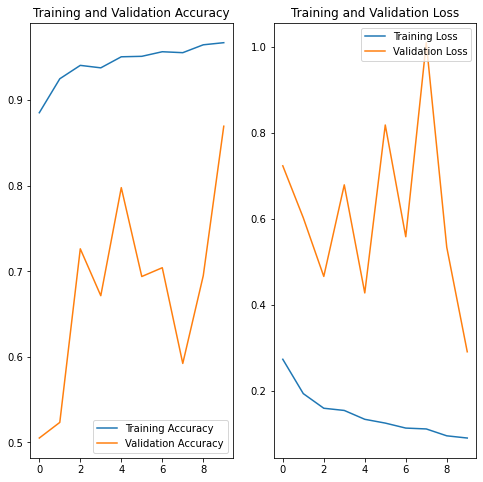

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
228/228 [==============================] - 19s 50ms/step - loss: 0.4380 - accuracy: 0.7834 - val_loss: 0.2911 - val_accuracy: 0.8897
Epoch 2/10
228/228 [==============================] - 10s 45ms/step - loss: 0.2869 - accuracy: 0.8913 - val_loss: 0.3113 - val_accuracy: 0.8821
Epoch 3/10
228/228 [==============================] - 13s 58ms/step - loss: 0.2445 - accuracy: 0.9051 - val_loss: 0.2595 - val_accuracy: 0.8971
Epoch 4/10
228/228 [==============================] - 10s 45ms/step - loss: 0.2193 - accuracy: 0.9125 - val_loss: 0.2324 - val_accuracy: 0.9061
Epoch 5/10
228/228 [==============================] - 10s 46ms/step - loss: 0.1873 - accuracy: 0.9255 - val_loss: 0.1752 - val_accuracy: 0.9333
Epoch 6/10
228/228 [==============================] - 10s 44ms/step - loss: 0.1567 - accuracy: 0.9398 - val_loss: 0.1752 - val_accuracy: 0.9337
Epoch 7/10
228/228 [==============================] - 10s 44ms/step - loss: 0.1589 - accuracy: 0.9349 - val_loss: 0.1361 - val_accuracy:

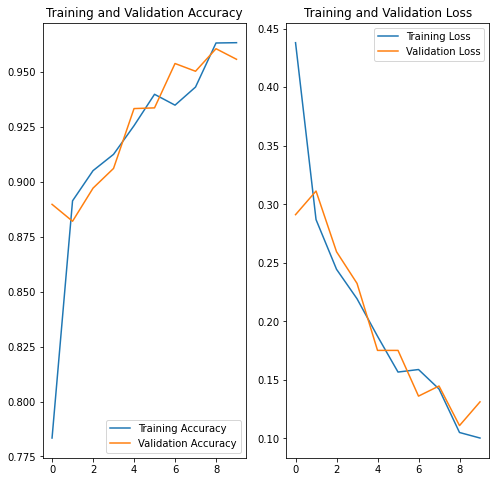

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()